## Latent Diffusion One-Click Notebook

Based on [this notebook](https://colab.research.google.com/github/multimodalart/latent-diffusion-notebook/blob/main/Latent_Diffusion_LAION_400M_model_text_to_image.ipynb#scrollTo=fmafGmcyT1mZ)
by [multimodalart](https://github.com/multimodalart),
with edits by [mdnestor](https://github.com/mdnestor).

In [ ]:
#@title Setup
model_path = "/models/ldm/text2img-large"
outputs_path = "/content/outputs"
!mkdir -p $model_path
!mkdir -p $outputs_path
print(f"Model will be stored at {model_path}")
print(f"Outputs will be saved to {outputs_path}")

!git clone https://github.com/crowsonkb/latent-diffusion.git
!git clone https://github.com/CompVis/taming-transformers
!pip install -e ./taming-transformers
!pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops
!pip install transformers
!pip install open_clip_torch
!pip install autokeras
!pip install tensorflow
import sys
sys.path.append(".")
sys.path.append('./taming-transformers')
from taming.models import vqgan 

%cd /content/latent-diffusion

import os
if os.path.isfile(f"{model_path}/latent_diffusion_txt2img_f8_large.ckpt"):
    print("Using saved model from Google Drive")
else:    
    !wget -O $model_path/latent_diffusion_txt2img_f8_large.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/txt2img-f8-large/model.ckpt


import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config

import argparse, os, sys, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm.auto import tqdm, trange
tqdm_auto_model = __import__("tqdm.auto", fromlist=[None]) 
sys.modules['tqdm'] = tqdm_auto_model
from einops import rearrange
from torchvision.utils import make_grid
import transformers
import gc
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from open_clip import tokenizer
import open_clip
import tensorflow as tf


def load_safety_model(clip_model):
    """load the safety model"""
    import autokeras as ak  # pylint: disable=import-outside-toplevel
    from tensorflow.keras.models import load_model  # pylint: disable=import-outside-toplevel
    from os.path import expanduser  # pylint: disable=import-outside-toplevel

    home = expanduser("~")

    cache_folder = home + "/.cache/clip_retrieval/" + clip_model.replace("/", "_")
    if clip_model == "ViT-L/14":
        model_dir = cache_folder + "/clip_autokeras_binary_nsfw"
        dim = 768
    elif clip_model == "ViT-B/32":
        model_dir = cache_folder + "/clip_autokeras_nsfw_b32"
        dim = 512
    else:
        raise ValueError("Unknown clip model")
    if not os.path.exists(model_dir):
        os.makedirs(cache_folder, exist_ok=True)

        from urllib.request import urlretrieve  # pylint: disable=import-outside-toplevel

        path_to_zip_file = cache_folder + "/clip_autokeras_binary_nsfw.zip"
        if clip_model == "ViT-L/14":
            url_model = "https://raw.githubusercontent.com/LAION-AI/CLIP-based-NSFW-Detector/main/clip_autokeras_binary_nsfw.zip"
        elif clip_model == "ViT-B/32":
            url_model = (
                "https://raw.githubusercontent.com/LAION-AI/CLIP-based-NSFW-Detector/main/clip_autokeras_nsfw_b32.zip"
            )
        else:
            raise ValueError("Unknown model {}".format(clip_model))
        urlretrieve(url_model, path_to_zip_file)
        import zipfile  # pylint: disable=import-outside-toplevel

        with zipfile.ZipFile(path_to_zip_file, "r") as zip_ref:
            zip_ref.extractall(cache_folder)

    loaded_model = load_model(model_dir, custom_objects=ak.CUSTOM_OBJECTS)
    loaded_model.predict(np.random.rand(10 ** 3, dim).astype("float32"), batch_size=10 ** 3)

    return loaded_model

def is_unsafe(safety_model, embeddings, threshold=0.5):
    """find unsafe embeddings"""
    nsfw_values = safety_model.predict(embeddings, batch_size=embeddings.shape[0])
    x = np.array([e[0] for e in nsfw_values])
    #print(x)
    return True if x > threshold else False
#NSFW CLIP Filter
safety_model = load_safety_model("ViT-B/32")
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')

def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cuda:0")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model = model.half().cuda()
    model.eval()
    return model

config = OmegaConf.load("configs/latent-diffusion/txt2img-1p4B-eval.yaml") 
model = load_model_from_config(config, f"{model_path}/latent_diffusion_txt2img_f8_large.ckpt")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
def run(opt):
    torch.cuda.empty_cache()
    gc.collect()
    if opt.plms:
        opt.ddim_eta = 0
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)
    
    os.makedirs(opt.outdir, exist_ok=True)
    outpath = opt.outdir

    prompt = opt.prompt


    sample_path = os.path.join(outpath, "samples")
    os.makedirs(sample_path, exist_ok=True)
    base_count = len(os.listdir(sample_path))

    all_samples=list()
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            with model.ema_scope():
                uc = None
                if opt.scale > 0:
                    uc = model.get_learned_conditioning(opt.n_samples * [""])
                for n in trange(opt.n_iter, desc="Sampling"):
                    c = model.get_learned_conditioning(opt.n_samples * [prompt])
                    shape = [4, opt.H//8, opt.W//8]
                    samples_ddim, _ = sampler.sample(S=opt.ddim_steps,
                                                    conditioning=c,
                                                    batch_size=opt.n_samples,
                                                    shape=shape,
                                                    verbose=False,
                                                    unconditional_guidance_scale=opt.scale,
                                                    unconditional_conditioning=uc,
                                                    eta=opt.ddim_eta)

                    x_samples_ddim = model.decode_first_stage(samples_ddim)
                    x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)

                    for x_sample in x_samples_ddim:
                        x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                        image_vector = Image.fromarray(x_sample.astype(np.uint8))
                        image = preprocess(image_vector).unsqueeze(0)
                        with torch.no_grad():
                          image_features = clip_model.encode_image(image)
                        image_features /= image_features.norm(dim=-1, keepdim=True)
                        query = image_features.cpu().detach().numpy().astype("float32")
                        unsafe = is_unsafe(safety_model,query,opt.nsfw_threshold)
                        if(not unsafe):
                          image_vector.save(os.path.join(sample_path, f"{base_count:04}.png"))
                        else:
                          raise Exception('Potential NSFW content was detected on your outputs. Try again with different prompts. If you feel your prompt was not supposed to give NSFW outputs, this may be due to a bias in the model')
                        base_count += 1
                    all_samples.append(x_samples_ddim)


    # additionally, save as grid
    grid = torch.stack(all_samples, 0)
    grid = rearrange(grid, 'n b c h w -> (n b) c h w')
    grid = make_grid(grid, nrow=opt.n_samples)

    # to image
    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
    
    Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'{prompt.replace(" ", "-")}.png'))
    display(Image.fromarray(grid.astype(np.uint8)))
    #print(f"Your samples are ready and waiting four you here: \n{outpath} \nEnjoy.")

import argparse

Model will be stored at /models/ldm/text2img-large
Outputs will be saved to /content/outputs


Sampling:   0%|          | 0/3 [00:00<?, ?it/s]

Data shape for DDIM sampling is (3, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

Data shape for DDIM sampling is (3, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

Data shape for DDIM sampling is (3, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

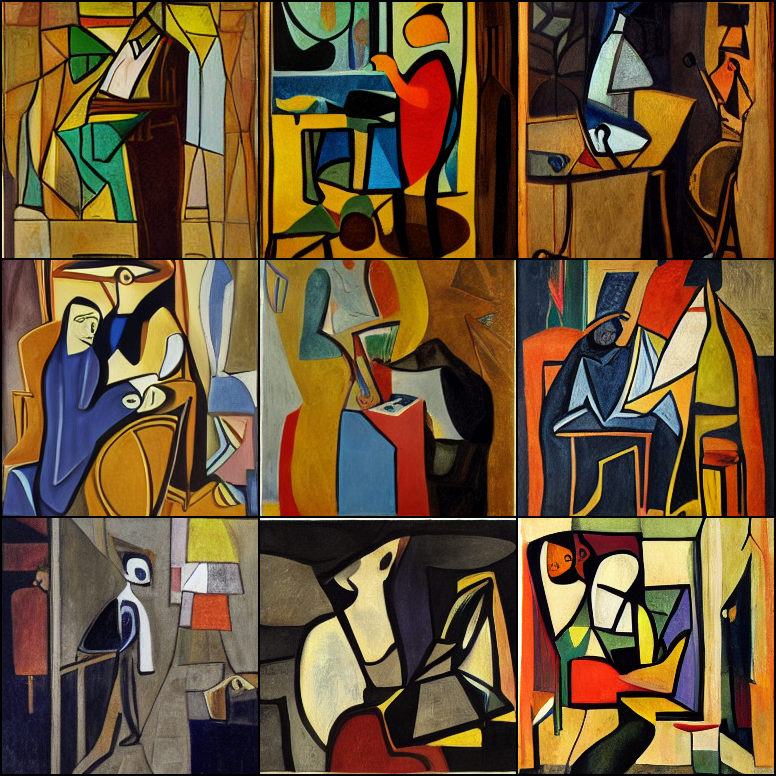

In [ ]:
args = argparse.Namespace(
  prompt = "a painting of a subway passenger in the style of picasso", 
  n_iter = 3, n_samples = 3, W = 256, H = 256,
  ddim_steps = 50, ddim_eta = 0.0, scale = 1.0,
  plms = False, nsfw_threshold = 1.0,
)
run(args)